# Init

## Imports

In [99]:
import sys, os

import tensorflow as tf

import numpy as np

import requests

import matplotlib

# Specify the backend of matplotlib to display graphs (here tkinter backend)
matplotlib.use("TkAgg")

from matplotlib import pyplot as plt

# Used to display matplotlib inside jupyter notebook
%matplotlib inline


# Disable tensorflow update warning
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Declare Global Consts

In [100]:
API_KEY  = 'A0P959H21M0HZXUB'
LOOKBACK = 24
PREDICT  = 2

# Create dataset

## Fetch data

In [101]:
def fetch_data(stock):
    r = requests.get(f'https://www.alphavantage.co/query?function=TIME_SERIES_MONTHLY&symbol={stock}&apikey={API_KEY}&datatype=csv')
    return r.text.split('\r\n')

dataset = fetch_data('AAPL')

In [102]:
def format_data(dataset):
    tab = []
    for line in dataset:
        tab.append(line.split(','))
    for line in tab[1:]:
        for i in range(len(line)):
            if i == 0:
                line[i] = len(tab) - tab.index(line) - 1
            line[i] = float(line[i])    
    labels = tab[0]
    tab = list(reversed(tab[1:]))
    tab = tab[1:] # Remove last line which is empty
    return labels, tab    

labels, dataset = format_data(dataset)

## Visualize dataset

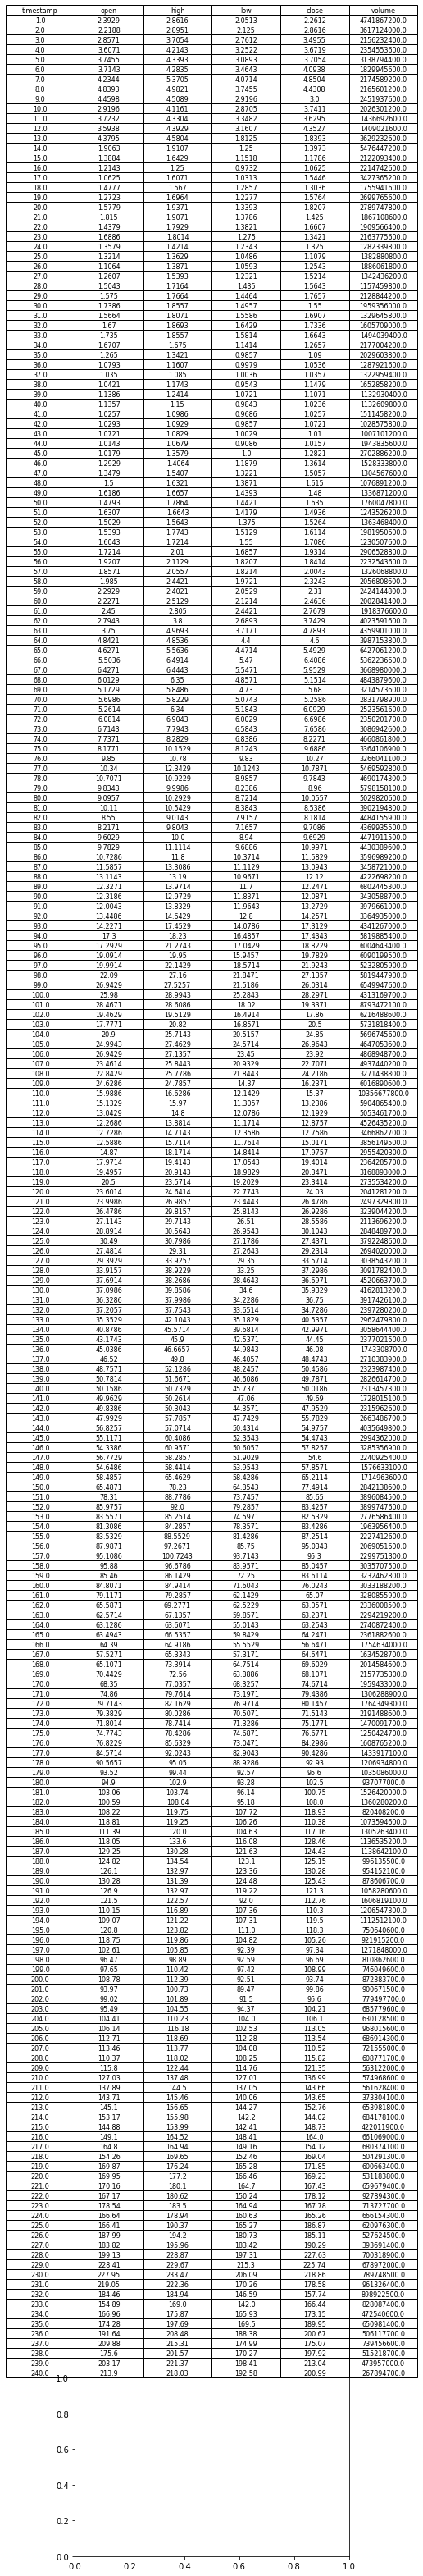

In [103]:
def visualize_data(labels, dataset):
    plt.table(cellText=dataset,
          colWidths = [0.25]*len(dataset[0]),
          colLabels=labels,
          cellLoc = 'center', rowLoc = 'center',
          loc='top')

visualize_data(labels, dataset)

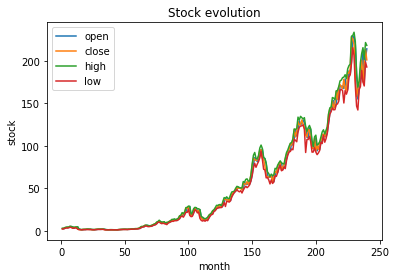

In [104]:
def plot_data(dataset):
    data_open = [data[1] for data in dataset]
    data_high = [data[2] for data in dataset]
    data_low = [data[3] for data in dataset]
    data_close = [data[4] for data in dataset]
    data_time = [data[0] for data in dataset]
    plt.plot(data_time , data_open)
    plt.plot(data_time , data_close)
    plt.plot(data_time , data_high)
    plt.plot(data_time , data_low)
    plt.title('Stock evolution')
    plt.ylabel('stock')
    plt.xlabel('month')
    plt.legend(['open', 'close', 'high', 'low'], loc='upper left')
    plt.show()

plot_data(dataset)

## Normalize data

In [105]:
def normalize_data(dataset):
    dataset = np.swapaxes(dataset,0,1)
    for i in range(len(dataset)):
        dataset[i] = (dataset[i] - min(dataset[i])) / (max(dataset[i]) - min(dataset[i]))
    dataset = dataset[1]
    return dataset

dataset = normalize_data(dataset)
print(dataset)

[6.06255967e-03 5.29693393e-03 8.10393512e-03 1.14021505e-02
 1.20107812e-02 1.18735754e-02 1.41607779e-02 1.68208985e-02
 1.51520016e-02 8.37878641e-03 1.19127143e-02 1.13436622e-02
 1.47988726e-02 3.92267752e-03 1.64514984e-03 8.79524107e-04
 2.11965310e-04 2.03785736e-03 1.13458610e-03 2.47849893e-03
 3.52117476e-03 1.86283206e-03 2.96531553e-03 1.51102242e-03
 1.35050927e-03 4.05020851e-04 1.08357370e-03 2.15483406e-03
 2.46574583e-03 3.18519655e-03 2.42792630e-03 2.88351979e-03
 3.16936512e-03 2.88659812e-03 1.10248347e-03 2.85845335e-04
 9.10307451e-05 1.22253851e-04 5.46624233e-04 5.33871133e-04
 5.01328741e-05 6.59643080e-05 2.54182467e-04 0.00000000e+00
 1.58314339e-05 1.22517708e-03 1.46704621e-03 2.13592429e-03
 2.65748209e-03 2.04489355e-03 2.71069330e-03 2.14867739e-03
 2.30875078e-03 2.59459612e-03 3.10955748e-03 3.98600325e-03
 3.70631459e-03 4.26877025e-03 5.62279762e-03 5.33343419e-03
 6.31366380e-03 7.82776455e-03 1.20305705e-02 1.68332119e-02
 1.58877235e-02 1.974223

## Split dataset

In [106]:
def split_dataset(dataset):
    x = []
    y = []
    for i in range(LOOKBACK, len(dataset)):
        x.append(dataset[i-LOOKBACK:i])
        y.append(dataset[i])
    return np.array(x), np.array(y)

x_train, y_train = split_dataset(dataset)
print(x_train.shape)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape, y_train.shape)

(216, 24)
(216, 24, 1) (216,)


# AI

## Define model

In [107]:
def define_model(data_len):
    print(data_len)
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(data_len, input_shape=(LOOKBACK,1), return_sequences=True))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(1, activation='linear'))
    return model

model = define_model(x_train.shape[0])

216


## Compile model

In [108]:
def compile_model(model):
    model.compile(optimizer='adam',loss='mse')
    return model

model = compile_model(model)

## Train AI

In [109]:
def train_ai(model, x_train, y_train):
    print(x_train.shape, y_train.shape)
    model.fit(x_train, y_train, epochs=200, validation_split=0.2)
    
train_ai(model, x_train, y_train)

(216, 24, 1) (216,)


ValueError: A target array with shape (216, 1) was passed for an output of shape (None, 24, 1) while using as loss `mean_squared_error`. This loss expects targets to have the same shape as the output.